In [16]:
import krotov
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy import *

In [17]:
a = tensor(destroy(50), qeye(2))
sm = tensor(qeye(50), destroy(2))

In [72]:
def hamiltonian(omega_r = 0.5, omega_m = 0.5,ampl0=1,g=1):
    """JC

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
        
    """
    N1=50
    n=10
    a = tensor(destroy(N1), qeye(2))
    sm = tensor(qeye(N1), destroy(2))
    H0 = omega_r * a.dag() * a + 0.5*omega_m * (sm.dag() * sm-sm *sm.dag())
    H1 = g * (a.dag()*sm + a*sm.dag())

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=np.pi*(2*n+1)/(2*g), t_rise=10, func="blackman"
        )

    return [H0, [H1, guess_control]]

In [73]:
H = hamiltonian()

In [74]:
tlist = np.linspace(0.1, np.pi*(2*10+1)/(2*1), 5000)

In [75]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

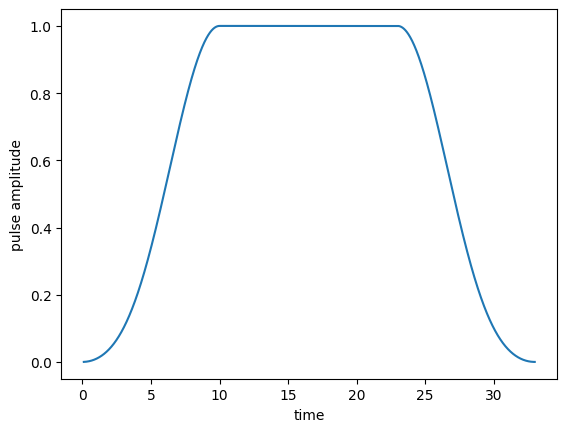

In [76]:
plot_pulse(H[1][1], tlist)

In [77]:
objectives = [
    krotov.Objective(
        initial_state= tensor(basis(50, 0), basis(2, 1)), target= tensor(basis(50, 1), basis(2, 0)), H=H
    )
]

objectives

[Objective[|Ψ₁₀(50⊗2)⟩ to |Ψ₁₁(50⊗2)⟩ via [H₈[50⊗2,50⊗2], [H₉[50⊗2,50⊗2], u₅(t)]]]]

In [78]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=np.pi*(2*10+1)/(2*1), t_rise=3, t_fall=3, func='blackman'
    )

In [79]:
pulse_options = {
    H[1][1]: dict(lambda_a=50, update_shape=S)
}

In [80]:
proj0 = sm.dag() * sm
proj1 = sm * sm.dag()

In [81]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])


In [82]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

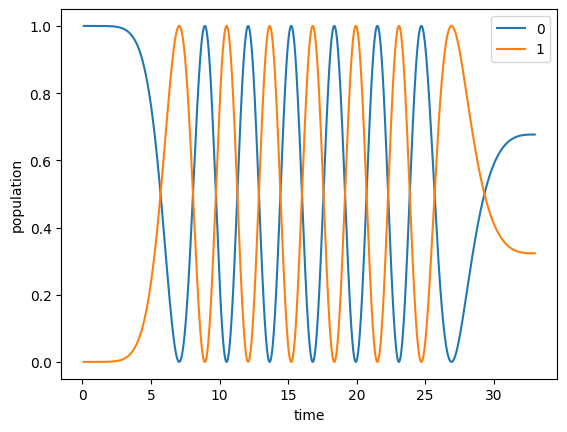

In [83]:
plot_population(guess_dynamics)

In [84]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     6.77e-01    0.00e+00   6.77e-01        n/a        n/a    16
1     4.33e-01    2.05e-03   4.35e-01  -2.44e-01  -2.42e-01    34
2     2.07e-01    2.02e-03   2.09e-01  -2.26e-01  -2.24e-01    33
3     7.77e-02    1.21e-03   7.89e-02  -1.29e-01  -1.28e-01    33
4     2.57e-02    5.00e-04   2.62e-02  -5.20e-02  -5.15e-02    33
5     8.09e-03    1.71e-04   8.26e-03  -1.76e-02  -1.74e-02    34
6     2.50e-03    5.43e-05   2.56e-03  -5.58e-03  -5.53e-03    34
7     7.71e-04    1.69e-05   7.88e-04  -1.73e-03  -1.72e-03    34


In [85]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2024-02-26 15:47:26
- Number of objectives: 1
- Number of iterations: 7
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2024-02-26 15:51:42 (0:04:16)

In [86]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

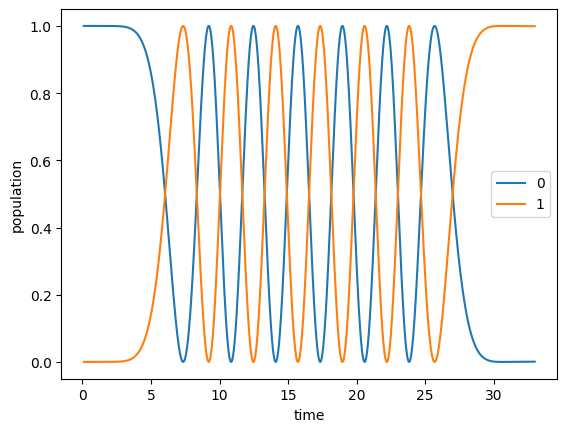

In [87]:
plot_population(opt_dynamics)

In [95]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(12, 15))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time', fontsize=14)
    ax_dyn.set_ylabel('population', fontsize=14)
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    plt.show(fig)

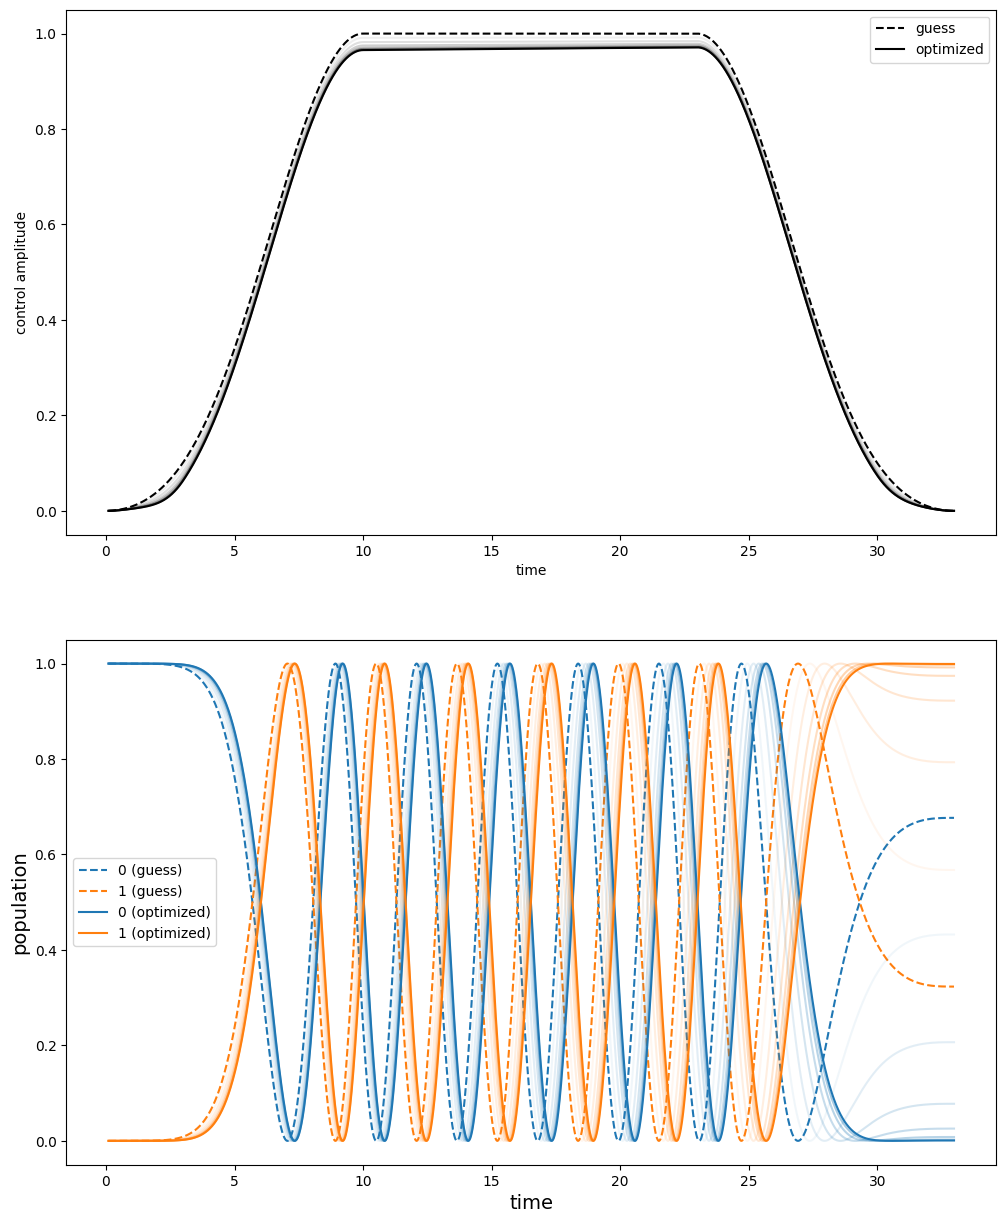

In [96]:
plot_iterations(opt_result)

In [4]:
import numpy as np

def vel_frenado(d):
    return 0.69 + np.sqrt(d*13.7)

In [6]:
vel_frenado(2.4)*3.6

23.126790509037292

In [21]:
import random 

random.random()

0.7243619561248367